## Part 1 Classification
This notebook is closely tied to/uses resources from [fastai course v3 lesson 1](https://course.fast.ai/videos/?lesson=1)


In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
from fastai import *
from fastai.vision import *

In [4]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url: str, fname: Union[pathlib.Path, str] = None, dest: Union[pathlib.Path, str] = None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



# Looking at the data

Unlike the fastai course lesson 1, we will be using the [MVTec Anomaly Detection Dataset](https://www.mvtec.com/company/research/datasets/mvtec-ad/) by [Bergmann et al., 2019](https://www.mvtec.com/fileadmin/Redaktion/mvtec.com/company/research/mvtec_ad.pdf). It consisists of 15 classes, and the goal is to train a model on the training set which consists of non-anomalous images, and pick out which images in the test set are anomalous.

We will first start off with basic clissification.

In [40]:
! ls ../../data/mv_tec_data/screw/test

000.png  005.png  010.png  015.png  020.png  025.png  030.png  035.png	040.png
001.png  006.png  011.png  016.png  021.png  026.png  031.png  036.png
002.png  007.png  012.png  017.png  022.png  027.png  032.png  037.png
003.png  008.png  013.png  018.png  023.png  028.png  033.png  038.png
004.png  009.png  014.png  019.png  024.png  029.png  034.png  039.png


In [22]:
??ImageDataBunch.from_name_func

In [24]:
Path('../../data/mv_tec_data').ls()

[PosixPath('../../data/mv_tec_data/capsule'),
 PosixPath('../../data/mv_tec_data/toothbrush'),
 PosixPath('../../data/mv_tec_data/grid'),
 PosixPath('../../data/mv_tec_data/screw'),
 PosixPath('../../data/mv_tec_data/metal_nut'),
 PosixPath('../../data/mv_tec_data/wood'),
 PosixPath('../../data/mv_tec_data/zipper'),
 PosixPath('../../data/mv_tec_data/transistor'),
 PosixPath('../../data/mv_tec_data/hazelnut'),
 PosixPath('../../data/mv_tec_data/bottle'),
 PosixPath('../../data/mv_tec_data/leather'),
 PosixPath('../../data/mv_tec_data/cable'),
 PosixPath('../../data/mv_tec_data/tile'),
 PosixPath('../../data/mv_tec_data/pill'),
 PosixPath('../../data/mv_tec_data/carpet')]

In [47]:
flatten_images=lambda x: ((x/'test').ls(),(x/'train').ls()) 
fnames=[flatten_images(p) for p in Path('../../data/mv_tec_data').ls()]
fnames=[i for m in fnames for i in m]
fnames=[i.ls() for m in fnames for i in m]
fnames=[i for m in fnames for i in m]

In [53]:
??ImageDataBunch.from_name_func

In [54]:
??get_transforms

In [51]:
tfms = get_transforms(do_flip=False)

In [58]:
bs = 64
bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [59]:
data = ImageDataBunch.from_name_func('../../data/mv_tec_data',fnames,lambda x:str(x).split('/')[4],
                                     ds_tfms=tfms, size=224,bs=bs).normalize(imagenet_stats)

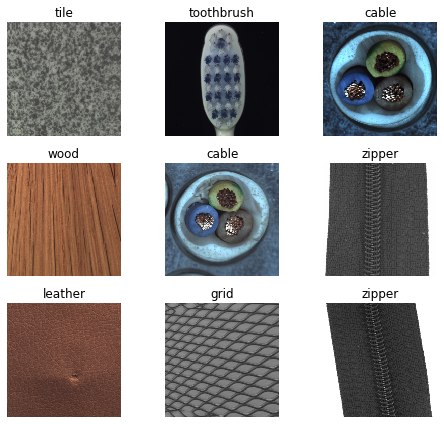

In [60]:
data.show_batch(rows=3, figsize=(7,6))

In [61]:
data.classes

['bottle',
 'cable',
 'capsule',
 'carpet',
 'grid',
 'hazelnut',
 'leather',
 'metal_nut',
 'pill',
 'screw',
 'tile',
 'toothbrush',
 'transistor',
 'wood',
 'zipper']

## Training: resnet34

More metrics can be found at [fastai metrics](https://docs.fast.ai/metrics.html)

In [64]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate,accuracy])

In [65]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [67]:
learn.fit(2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.018827,0.000091,0.000000,1.000000,00:45
1,0.005313,0.000015,0.000000,1.000000,00:46


In [68]:
learn.save('stage-1')

Ummm... obviously this is way too easy.

## Results

In [69]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

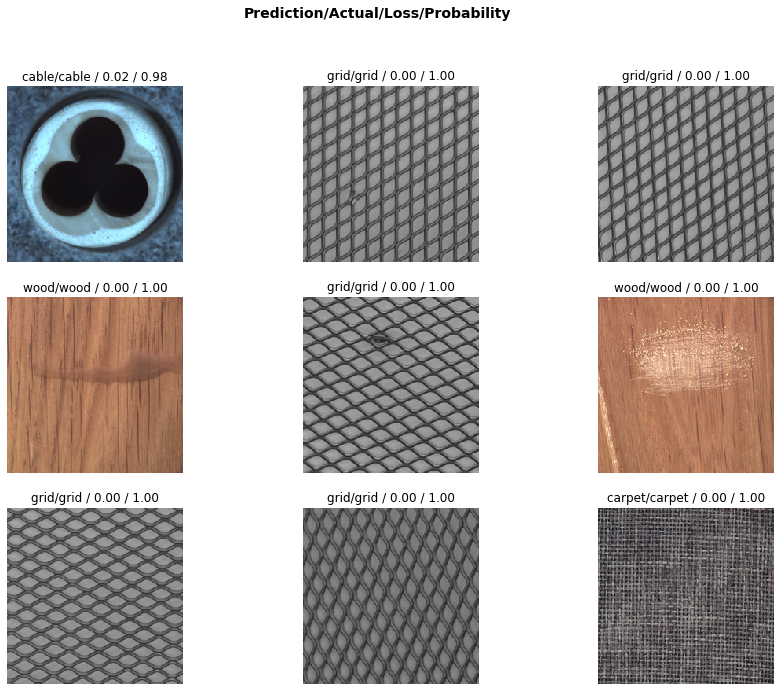

In [70]:
interp.plot_top_losses(9, figsize=(15,11))

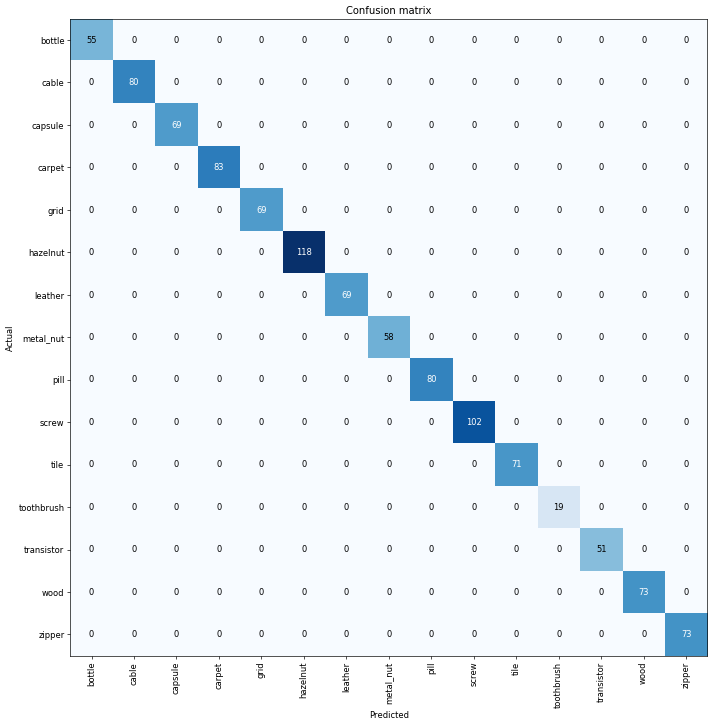

In [71]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

## More Challenging

Now are are going to do something a little more challenging. Instead of classifying different types of components, we want to classify *whether a component is defective or not*. 

In [2]:
! ls ../../data/mv_tec_data/screw/test

good  manipulated_front  scratch_head  scratch_neck  thread_side  thread_top


In [9]:
path=Path('../../data/mv_tec_data')
tfms = get_transforms(do_flip=False)
bs = 64
bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [10]:
lls=(ImageList.from_folder(path,extensions=['.png'])
              .split_by_rand_pct(.2)
              .label_from_func(lambda x: 'good' if str(x).__contains__('good') else 'defective'))

In [11]:
data=ImageDataBunch.create_from_ll(lls,ds_tfms=tfms,size=224,bs=bs).normalize(imagenet_stats)

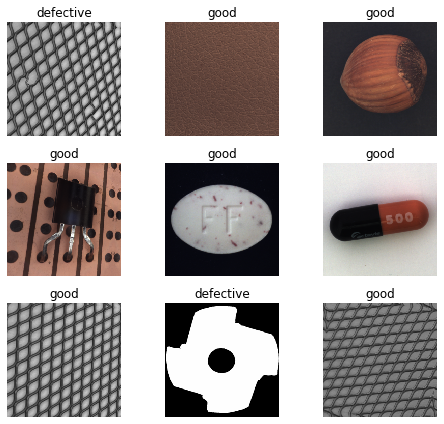

In [12]:
data.show_batch(rows=3,figsize=(7,6))

Love graph plotting: [ShowGraph](https://docs.fast.ai/train.html#ShowGraph)

In [19]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate,accuracy],callback_fns=ShowGraph)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.463841,0.300671,0.131619,0.868381,00:54
1,0.369020,0.357618,0.126324,0.873676,00:56


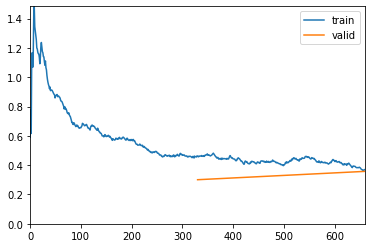

In [20]:
learn.fit(4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.336946,0.325983,0.121029,0.878971,00:53
1,0.342809,0.318374,0.125567,0.874433,00:55
2,0.302081,0.254255,0.112708,0.887292,00:57
3,0.264735,0.257002,0.119516,0.880484,00:56


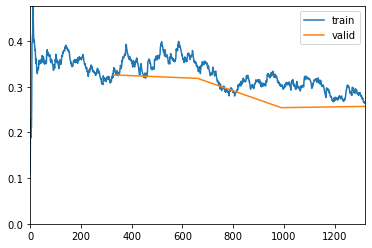

In [21]:
learn.fit_one_cycle(4)

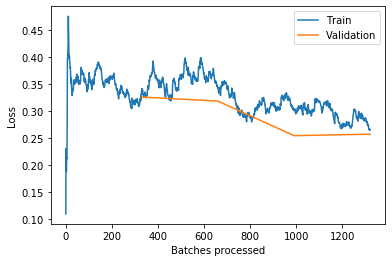

In [22]:
learn.recorder.plot_losses()

In [25]:
interp=ClassificationInterpretation.from_learner(learn)

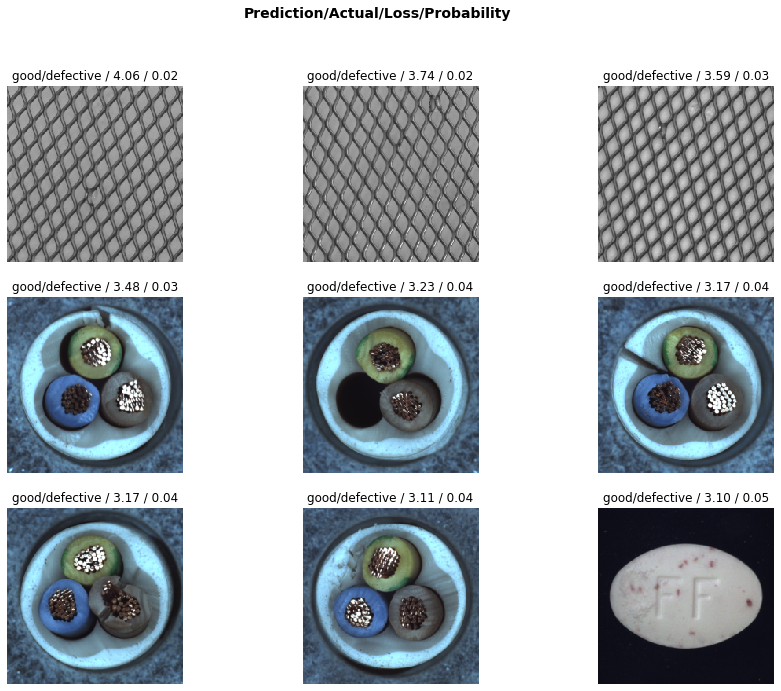

In [26]:
interp.plot_top_losses(9, figsize=(15,11))

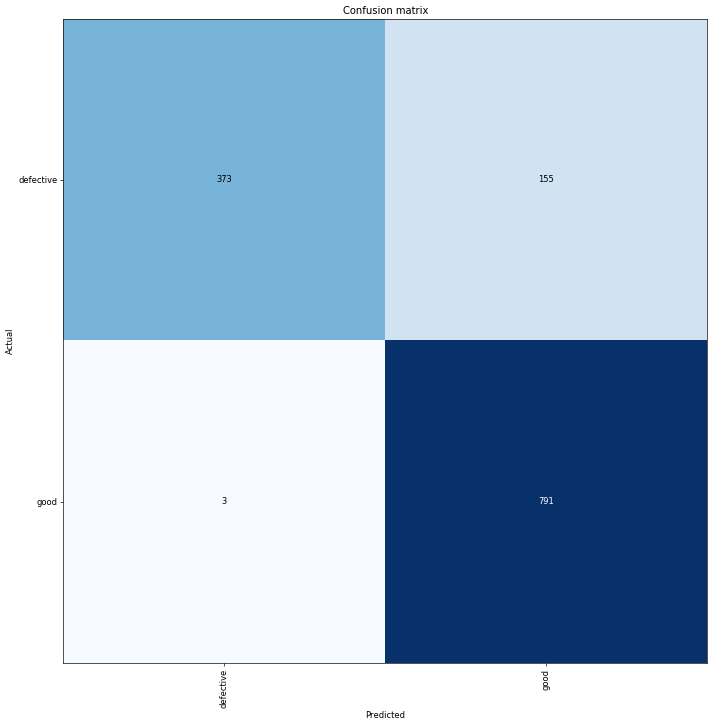

In [27]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

## Hardest

We going to see if we can beat any of the benchmarks referenced in their paper. The ultamate goal is to classify defective vs good components **by only referencing good training data**. 

In [131]:
! ls ../../data/mv_tec_data/screw/

ground_truth  license.txt  readme.txt  test  train


In [165]:
path=Path('../../data/mv_tec_data')

In [214]:
??ItemList

In [203]:
lls=(ImageList.from_folder(path,extensions=['.png'])
              .split_by_valid_func(lambda x: str(x).__contains__('test'))
              .label_from_func(lambda x: 'good' if str(x).__contains__('good') else 'defective'))

In [207]:
data=ImageDataBunch.create_from_ll(lls,ds_tfms=tfms,size=224,bs=bs).normalize(imagenet_stats)

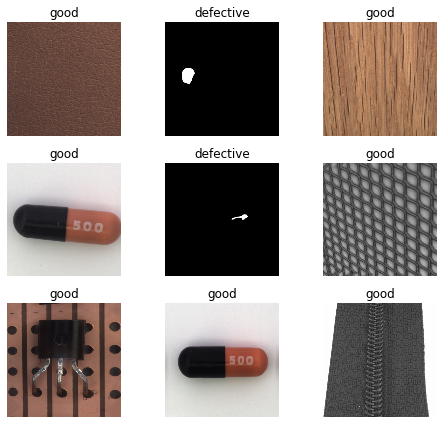

In [208]:
data.show_batch(rows=3, figsize=(7,6))

In [209]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate,accuracy])

In [211]:
learn.fit(2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.024643,13.362029,0.726957,0.273043,00:53
1,0.014949,16.077559,0.729275,0.270725,00:54


## Some Ideas

We can look at the gan API added by fastai [ganw](https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson7-wgan.ipynb).

In [28]:
from fastai.vision.gan import *

In [29]:
??GANItemList

In [30]:
def get_data(bs, size):
    gls=None
    for p in path.ls():
        if p.parts[-1]=='models':continue
        if gls is None: gls=GANItemList.from_folder(p/'train/good', noise_sz=100)
        else:           gls.add(GANItemList.from_folder(p/'train/good', noise_sz=100))
        
    return (gls
               .split_none()
               .label_from_func(noop)
               .transform(tfms=[[crop_pad(size=size, row_pct=(0,1), col_pct=(0,1))], []], size=size, tfm_y=True)
               .databunch(bs=bs)
               .normalize(stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])], do_x=False, do_y=True))

In [31]:
data=get_data(128, 64)

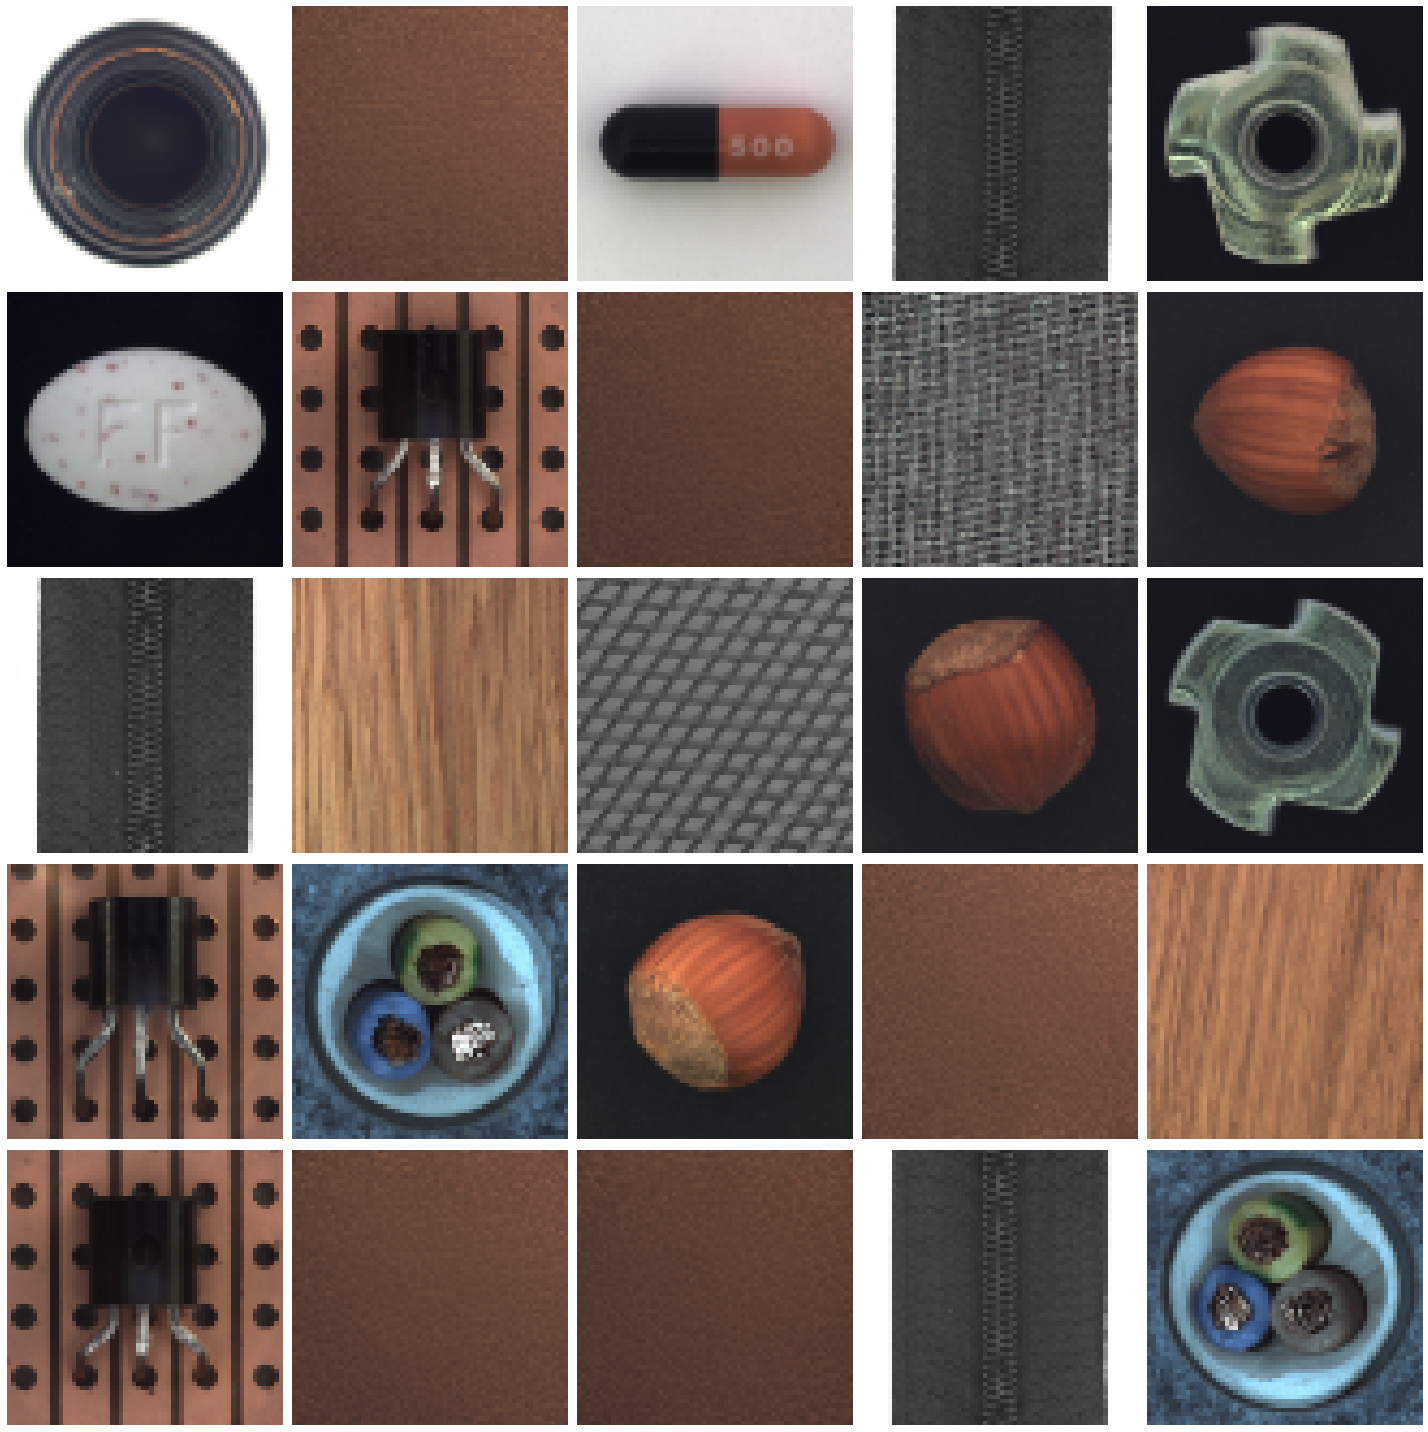

In [32]:
data.show_batch(rows=5)

In [33]:
generator = basic_generator(in_size=64, n_channels=3, n_extra_layers=1)
critic    = basic_critic   (in_size=64, n_channels=3, n_extra_layers=1)

In [34]:
learn = GANLearner.wgan(data, generator, critic, switch_eval=False,
                        opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,-0.424874,#na#,0.377012,-0.554119,00:26
1,-0.684947,#na#,0.515293,-0.911103,00:27
2,-0.841053,#na#,0.589961,-1.131911,00:28
3,-0.989431,#na#,0.630378,-1.283281,00:27
4,-1.041348,#na#,0.664785,-1.373704,00:26
5,-1.068677,#na#,0.688593,-1.433844,00:26
6,-1.128240,#na#,0.703032,-1.474694,00:27
7,-1.131567,#na#,0.717260,-1.502636,00:27
8,-1.126943,#na#,0.728043,-1.520787,00:27
9,-1.168023,#na#,0.735387,-1.535406,00:28


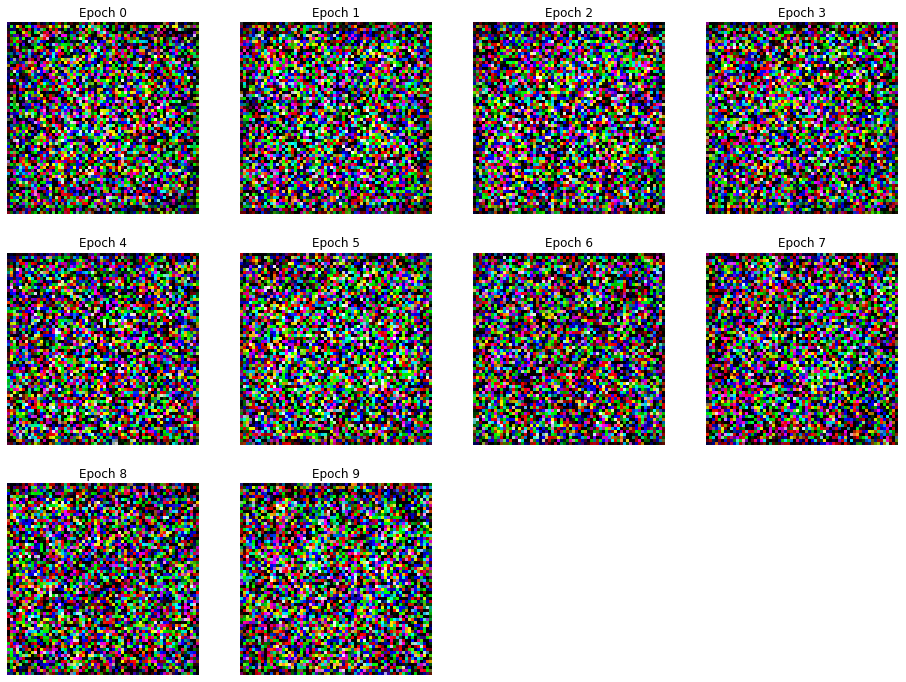

In [ ]:
learn.fit(30,2e-4)

In [ ]:
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(ds_type=DatasetType.Train, rows=16, figsize=(8,8))